Sentiment Analysis Smartphone

ติดตั้ง Library Pythai NLP






In [10]:
!pip install pythainlp


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Library ที่จะใช้

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import json
import requests
from pythainlp import word_tokenize
from pythainlp.util import normalize
from pythainlp.tag import pos_tag
from pythainlp.util import Trie

from pythainlp.corpus.common import thai_stopwords
from pythainlp.corpus.common import thai_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
thai_stopwords = list(thai_stopwords())

Load Files Model ของ iPhone ที่เป็นไฟล์ JSON


In [2]:
with open('model_iphone.json', 'r', encoding="utf-8") as file:
    model_ip = json.load(file)

เก็บชื่อ Model ของ iPhone ไว้ใน List

In [3]:
model_word = []
for i in model_ip:
    model_word.append(i)
    for j in model_ip[i]:
        model_word.append(j)

model = {i for i in model_word}

# Load Data To Dataframe

In [4]:
df=pd.read_table("iphone14_new.txt",names=['comment'],header=None)
print("Comment Data {:,} rows".format(df.shape[0]))
df.head()

Comment Data 2,331 rows


,comment
0,เป็นกับสี
1,อยากได้จัง ตังไม่พอ
2,ใส่เคส rhinoshield เข้ากับขอบฟิล์มกระจกเลนส์กล...
3,ไม่เคยใช้ไอโฟน อยากขอคำแนะนำใช้ 14 ตัวไหนดี ปก...
4,เลือกไม่ถูกค่ะช่วยเลือกที 13pm 14 14pro


# Preprocessing Data

In [5]:
def showConfisionMatrix(label, predict):
  cm = confusion_matrix(label, predict)
  ac = accuracy_score(label, predict)
  print("Accuracy score: {:.4f}".format(ac))
  print("--"*30)
  print(classification_report(predict,label))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
  fig ,ax = plt.subplots(figsize=(5,5))
  disp.plot(ax=ax, values_format=",d")

Function แก้ไขคำผิด ในส่วนของ Model Smartphone

In [6]:
def changes_word_of_model(text, dict_word):
    correct_text = []
    for word in text:
        for i in dict_word:
            if word in dict_word[i]:
                correct_word = i
                break
        else:
            correct_word = word
        correct_text.append(correct_word)
    return " ".join(correct_text)

Function แก้ไขคำที่ผิดของประโยค

In [7]:
def changes_incorrect(text, dict_word):
    text = text.split()
    correct_text = []
    for word in text:
        for i in dict_word:
            if word in dict_word[i]:
                correct_word = i
                break
        else:
            correct_word = word
        correct_text.append(correct_word)
    return " ".join(correct_text)

Function ลบคำที่มีตัวสะกดซ้ำ

In [8]:
def repeat_letter(text):
    def _replace_rep(m):
        c, _ = m.groups()
        return f"{c} "

    re_rep = re.compile(r"(\S)(\1{2,})")
    return re_rep.sub(_replace_rep, text)

Function ลบอิโมจิ

In [9]:
def remove_emojis(data):
    emoj = re.compile("["
                      u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      u"\U00002500-\U00002BEF"  # chinese char
                      u"\U00002702-\U000027B0"
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      u"\U0001f926-\U0001f937"
                      u"\U00010000-\U0010ffff"
                      u"\u2640-\u2642"
                      u"\u2600-\u2B55"
                      u"\u200d"
                      u"\u23cf"
                      u"\u23e9"
                      u"\u231a"
                      u"\ufe0f"  # dingbats
                      u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [10]:
# incorrect = {
#     "ดี": ["ดร"],
#     "ศัพท์": ["ศัทพ์"]
# }

keywords_model = [i for i in model_ip]
keywords_option = ['กล้อง', 'หน้าจอ','จอ', 'ดีไซน์', 'โปรเซสเซอร์', 'แบตเตอรี่','ชิพ']
keywords = keywords_model+keywords_option
words = model.union(thai_words())
custom_dictionary_trie = Trie(words)

def text_process(data):
    data = "".join(u.lower() for u in data if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ",
                    "/", "<", ">", "^", "-", "*", "(", ")", "%", "_", ",", "#", "'", " ", "{", "}", "…","&"))
    data = re.sub(r"(\d{1,})[g][b]", '', data)
    data = re.sub(r"(\d{2,})[h][z]", '', data)
    data = re.sub(r"[0-9]{3,}", '', data)
    data = repeat_letter(data)
    data = normalize(data)
    data = word_tokenize(
        data, custom_dict=custom_dictionary_trie, keep_whitespace=False)
    data = changes_word_of_model(data, model_ip)
    # final = changes_incorrect(final, incorrect)
    data = word_tokenize(data,custom_dict=custom_dictionary_trie,keep_whitespace=False)
    
    relevant_words = [word for word in data if word in keywords]
    if not relevant_words:
        return None

    tag_word = pos_tag(data,corpus="orchid_ud")
    tokens = [word for word in tag_word if word not in thai_stopwords]
    # # # print(tokens)

    data = "|".join(word for word in data if word not in thai_stopwords)
    return data



df['clean_data'] = df['comment'].apply(remove_emojis)
df['clean_data'] = df['clean_data'].apply(text_process)
df = df.dropna()
df = df.drop_duplicates()
# df.to_csv("testttttttt.csv", encoding="utf-8")
df.reset_index(drop=True, inplace=True)
df.iloc[1:11]
# df

,comment,clean_data
1,ไม่เคยใช้ไอโฟน อยากขอคำแนะนำใช้ 14 ตัวไหนดี ปก...,ไอโฟน|คำแนะนำ|iPhone 14|ตัว|ดี|ปกติ|ซัมซุง
2,เลือกไม่ถูกค่ะช่วยเลือกที 13pm 14 14pro,เลือก|เลือก|iPhone 13 Pro Max|pro
3,กำลังตัดสินใจอยู่เลยค่ะว่าจะเลือกตัวไหนดีระหว่...,ตัดสินใจ|อยู่เลย|เลือก|ตัว|ดี|iPhone 14 Plus|i...
4,เราเลือก14proมา ตอนแรกก็คิดว่ามันจะเกะกะไหมในส...,เลือก|iPhone 14 Pro|ตอนแรก|เกะกะ|ไหม|dynamicis...
5,กำลังตัดสินใจ 14 พลัส vs 13 โปรแม็กครับ,ตัดสินใจ|iPhone 14 Plus|vs|iPhone 13 Pro Max
6,Iphone 14 ธรรมดาให้ฟิล 13 pro ไหมคะ?,iPhone 14|ธรรมดา|ฟิล|iPhone 13 Pro|ไหม
7,เล็งไอโฟน 14 ไว้ค่ะ ส่วนตัวไม่ชอบ dynamic isla...,เล็ง|ไอโฟน|iPhone 14|ส่วนตัว|ชอบ|dynamicisland...
8,ถ้าอยากขายดี ทำจอใหญ่ เลยเป็นตัวเริ่มต้น,ขายดี|ทำ|จอ|เป็นตัว|เริ่มต้น
9,14+ แบตโคตรอึด เล่นได้ทั้งวันจริงๆ,iPhone 14 Plus|แบต|โคตร|อึด|เล่น|ทั้งวัน
10,พิจารณาจากฟีเจอร์+ราคาแล้ว 13 pro max ฟรีเมี่ย...,พิจารณา|ฟีเจอร์|+|ราคา|iPhone 13 Pro Max|ฟรี|เ...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment     913 non-null    object
 1   clean_data  913 non-null    object
dtypes: object(2)
memory usage: 14.4+ KB


Function AIForThai Sentiment Analysis

In [11]:
def analyze_sentiment_AIforthai(df, column_name):
    api_key = "FOFZpO9UFwSMquHMwVmZ7cjebmv0Yv8a"
    results_df = pd.DataFrame(columns=["comment", "sentiment_data"])
    for index, row in df.iterrows():
        comment = row[column_name]
        response = requests.post(
            "https://api.aiforthai.in.th/ssense",
            data={"text": comment},
            headers={"Apikey": api_key}
        )
        sentiment_data = dict(response.json())
        if sentiment_data["sentiment"]["score"] == "0":
            sentiment_data = "neu"
        else:
            sentiment_data = sentiment_data["sentiment"]['polarity'][:3]
        results_df.loc[index] = [comment, sentiment_data]
    return results_df

In [14]:
results_df = analyze_sentiment_AIforthai(df[:120], "clean_data")
results_df

,comment,sentiment_data
0,ใส่|เคส|rhinoshield|เข้ากับ|ขอบ|ฟิล์ม|กระจก|เล...,neu
1,ไอโฟน|คำแนะนำ|iPhone 14|ตัว|ดี|ปกติ|ซัมซุง,pos
2,เลือก|เลือก|iPhone 13 Pro Max|pro,neu
3,ตัดสินใจ|อยู่เลย|เลือก|ตัว|ดี|iPhone 14 Plus|i...,pos
4,เลือก|iPhone 14 Pro|ตอนแรก|เกะกะ|ไหม|dynamicis...,neg
...,...,...
115,จบ|iPhone 12|ต่อไป|พับ|ระบบ|เอน|ดร|อย,neu
116,iPhone 14 Pro|ผม|เปิดไฟ|ร์|word|iPhone XS|ls|ล...,neu
117,รอ|ดู|15|ดีกว่า|iPhone 11|พัง,neg
118,iphone|ดู|iPhone 13|ซื้อ|iPhone 14|คุ้ม,pos


In [15]:
results_df2 = analyze_sentiment_AIforthai(df[120:240], "clean_data")
results_df2

,comment,sentiment_data
120,พี่|iPhone 13 Pro|iPhone 14|ผม|อยากรู้|แรง|อ่ะ...,neu
121,iPhone 6s|iPhone 14|ดีขึ้น,pos
122,ตัวเรา|ไอโฟน|iPhone 14|ธรรมดา|คนใช้|แอน|ดร|อย|...,neu
123,ใจ|คน|ชื้อ|se|3|ผม|ชื้อ|iPhone 14|ลอง|ใข้|ดู|ล...,neu
124,iPhone 14|รู้สึก|แบต,neu
...,...,...
235,ผม|iPhone 8|+|4|ปี,neu
236,iPhone 12|เจอ|แอน|ดร|อย|จอ|ฟา|ส|ชา|จ|w|โลก|ผม,neu
237,ป้า|ผม|iPhone 6s|ตอนนี้|ใช้ได้|แบต|2|รอบ|ตอนนี...,pos
238,ย้อม|เกินไป|เล่น|ใส่|เดิม|แบบนี้|ซื้อ|iPhone 1...,pos


In [17]:
results_df3 = analyze_sentiment_AIforthai(df[240:360], "clean_data")
results_df3

,comment,sentiment_data
240,iPhone 11|3|ปี|เวลา|สะ|ออกมา|แบบนี้|จ่าย|ซื้อ|...,neu
241,iPhone 14|คุ้ม|ผม|กั๊ก|สเปค,pos
242,สอบถาม|ย้าย|แอน|ดร|อย|ios|ลังเล|iPhone 13|iPho...,pos
243,พี่|คนใช้|iPhone 11|เก่า|พัง|อยู่แล้ว|iPhone 1...,neg
244,เหมือน|iPhone 14|ออกมา|ขัดตาทัพ|งั้น|รอ|15|ควา...,pos
...,...,...
355,รู้สึก|iPhone 13 Pro|หวด,neu
356,iPhone 13 Mini|vs|iPhone 12|ฮะ|พี่,neu
357,iPhone 14|เปิดตัว|ผม|iPhone 13 Pro,neu
358,แบบนี้|ผม|iPhone XR|iPhone 14|ดี|ทำ|งา|นอ|อนล|...,pos


In [20]:
results_df4 = analyze_sentiment_AIforthai(df[360:480], "clean_data")
results_df4

,comment,sentiment_data
360,ผม|iPhone 6s|iPhone 6|ปีก|ว่าแต่|คุ้มค่า|iPhon...,pos
361,ถอย|iPhone 14|iPhone 11|ตอนแรก|เล็ง|iPhone 13 ...,neg
362,ห่าง|iPhone 14|โปร|แทนที่จะ|ไดนามิก|ชิป|ตัวใหม...,neg
363,iPhone 13 Pro Max|ดีกว่า,pos
364,รัก|ตั้ม|ซื้อ|ไอโฟน|iPhone 14|โปร|์แม็ส|รัก|ชอ...,pos
...,...,...
475,iPhone 14|สีม่วง|ไอติม|รส|เผือก,neu
476,iPhone 14|สี|ขาว|ไอติม|กะทิ,neu
477,iPhone 14|สีแดง|ไอติม|สต|รอ|เบอ|รี่,neu
478,iPhone 14|สี|ดำ|ไอติม|ถั่วดำ,neu


In [21]:
results_df5 = analyze_sentiment_AIforthai(df[480:600], "clean_data")
results_df5

,comment,sentiment_data
480,iPhone 14 Pro|ro|ผม|ซื้อ|3|เดือน|โดน|แกะ|เครื่...,neg
481,รีวิว|s|23|iPhone 14|ตัว|ธรรมดา,neu
482,ทราบ|ติด|ฟิล์ม|กล้อง|ไหม|มีส่วนช่วย|รอย|กันกระ...,neg
483,ซื้อ|iPhone 13 Pro|iPhone 13 Pro Max|หา|เคส|เห...,neu
484,ด่า|สัก|iPhone X,neg
...,...,...
595,ผลิตภัณฑ์|จอ|promotion|สักพัก|iPhone 14 Plus|จ...,neu
596,ส่วนตัว|ชอบ|รูปร่าง|iPhone 14 Plus|รู้สึก|เพรี...,pos
597,+|สำหรับ|ของเก่า|ย้อมแมวขาย|คน|รุ่น|สแกน|หน้า|...,neg
598,iPhone X|ตัดสินใจ|iPhone 14 Pro Max|iPhone 14 ...,pos


In [22]:
results_df6 = analyze_sentiment_AIforthai(df[600:720], "clean_data")
results_df6

,comment,sentiment_data
600,ไอโฟน|iPhone 14 Pro Max|ขาย|ศูย|ais|สาขา|ไหม,neu
601,ตอนแรก|เปิดตัว|อยากได้|iPhone 14 Plus|ดู|สเป็ค...,pos
602,คลิป|20|นาที|เข้าถึง|รีวิว|นาที|iPhone 13|iPho...,neu
603,iPhone 13|ram|4|gb,neu
604,iPhone 14|ram|iPhone 6|gb,neu
...,...,...
715,dynamicisland|มาจาก|ทัช|บาร์|macbook|เดี๋ยว|อี...,pos
716,เวลา|ติด|ฟิล์ม|หน้าจอ|ล่ะ|ตัว|ฟิล์ม|เว้น|รู|กล...,neu
717,samsunggalaxy|22|+กเบ|iPhone 14 Pro|ro|ดีกว่า,pos
718,หน้าจอ|burn|ไหม|อนาคต,neu


In [23]:
results_df7 = analyze_sentiment_AIforthai(df[720:840], "clean_data")
results_df7

,comment,sentiment_data
720,อยากได้|อยากได้|ถอย|iPhone 13|2|เดือน|ลอง|หันม...,pos
721,ลบ|ตอน|ดู|หนัง|กด|ค้าง|ลบ|รู|กล้อง|ดี,pos
722,อยากได้|iPhone 13 Pro|m|มือ|สั่น,pos
723,เจอ|กล้อง|หน้า|บัง|appyoutube|ผม|คิดหนัก,neg
724,ผม|ลอง|เทียบ|iPhone 13 Pro|iPhone 14 Pro|ro|เร...,pos
...,...,...
835,andlikeapple|’|sbatteryitdoesn|’|tannouncenumb...,neu
836,ทำ|สแกน|นิ้ว|จอ|ห|ติ|ส,neu
837,ว้าว|รู|กล้อง|แคปซูล|แก้|ขยาย|าน|สวยงาม|สไตล์|...,pos
838,อยากรู้|การใช้งาน|ทั้งวัน|แบ็ต|เต|อร|รี่|หรอ|อ...,pos


In [24]:
results_df8 = analyze_sentiment_AIforthai(df[840:960], "clean_data")
results_df8

,comment,sentiment_data
840,จอ|แอบ|ดับ|เหมือน|เครื่อง|มั้ง|lgv|50|ล็อก|จอ|...,neg
841,ไทย|เปิดตัว|แพง|เจอ|ประเทศ|ญี่ปุ่น|แพง|45|พัน|...,neg
842,รู้สึก|เหมือน|เหมือน|แอน|ดร|อย|ติ่ง|หน้าจอ|ยัน...,pos
843,ติ่ง|ยืด|หด|ก้อ|บัง|จอ|ยุ|ดี|ดู|เหมือน|เครื่อง...,pos
844,ดู|พี่|อู๋|ปีก่อน|คน|รีวิว|เรื่อง|พี่|อู๋|ที่ม...,pos
...,...,...
908,ผม|iphone|แนะนำ|iPhone 13|ดี|iPhone 14|ดี,pos
909,กล้อง|ถ่าย|คลิป|ชัด,pos
910,iPhone 14 Pro|แน่|รู้|สี|ดี|สวย|สี,pos
911,แพง|มีระดับ|หา|ช่อง|ภาพ|เสียง|ว้าว|iphone|อีกแ...,neu


In [27]:
final_result = pd.concat([results_df,results_df2,results_df3,results_df4,results_df5,results_df6,results_df7,results_df8])
final_result = final_result[final_result["sentiment_data"]!="neu"]
final_result.reset_index(drop=True, inplace=True)
final_result.to_csv("final_data.csv")
final_result

,comment,sentiment_data
0,ไอโฟน|คำแนะนำ|iPhone 14|ตัว|ดี|ปกติ|ซัมซุง,pos
1,ตัดสินใจ|อยู่เลย|เลือก|ตัว|ดี|iPhone 14 Plus|i...,pos
2,เลือก|iPhone 14 Pro|ตอนแรก|เกะกะ|ไหม|dynamicis...,neg
3,เล็ง|ไอโฟน|iPhone 14|ส่วนตัว|ชอบ|dynamicisland...,pos
4,ขายดี|ทำ|จอ|เป็นตัว|เริ่มต้น,pos
...,...,...
544,ตอนแรก|ซื้อ|promax|dynamixisland|ตอนนี้|คิดดู|...,pos
545,ว้าว|เรย|iPhone 13 Pro|ต่อไป|มีปัญหา|จอ|บาก|อย...,neg
546,ผม|iphone|แนะนำ|iPhone 13|ดี|iPhone 14|ดี,pos
547,กล้อง|ถ่าย|คลิป|ชัด,pos


In [28]:
final_result['sentiment_data'].value_counts()

pos    418
neg    131
Name: sentiment_data, dtype: int64

สร้าง Visualization ของ WordCloud เพื่อดูความถี่ของข้อมูล

In [63]:
# from wordcloud import WordCloud

# pos_word_all = final_result[final_result['sentiment_data'] == 'neg']
# pos_word_all = "|".join(text for text in final_result['comment'])
# # pos_word_all
# reg = r"[ก-๙a-zA-Z0-9']+"
# fp = 'THSarabunNew.ttf'
# wordcloud = WordCloud(stopwords=thai_stopwords,background_color = 'white', max_words=500, height = 500, width=1000, font_path=fp, regexp=reg).generate(pos_word_all)
# plt.figure(figsize = (10,8))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

ตัวอย่างที่ทดลองจากไฟล์ data.csv ขึ้นละอันกับข้างบน

In [84]:
from sklearn.model_selection import train_test_split
data = pd.read_csv("final_data.csv",index_col=0)
# data = data[data["sentiment_data"]!="neu"]

X = data['comment']
y = data['sentiment_data']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)
y_test.value_counts()

pos    126
neg     39
Name: sentiment_data, dtype: int64

In [85]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(analyzer=lambda x:x.split('|'))
X_train = cvec.fit_transform(X_train)
X_test = cvec.transform(X_test)

In [95]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

Accuracy score: 0.8364
------------------------------------------------------------
              precision    recall  f1-score   support

         neg       0.33      0.93      0.49        14
         pos       0.99      0.83      0.90       151

    accuracy                           0.84       165
   macro avg       0.66      0.88      0.70       165
weighted avg       0.94      0.84      0.87       165



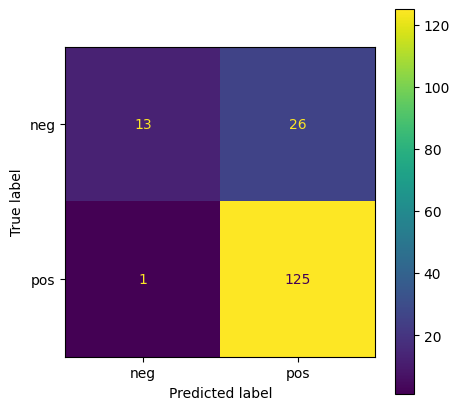

In [96]:
prediction1 = model1.predict(X_test)
# print("-"*20+"LogisticRegression Model"+"-"*20)
acc1 = accuracy_score(y_test, prediction1)
showConfisionMatrix(y_test, prediction1)

In [ ]:
model2 = svm.SVC()
model2.fit(X_train, y_train)

Accuracy score: 0.7636
------------------------------------------------------------
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00         0
         pos       1.00      0.76      0.87       165

    accuracy                           0.76       165
   macro avg       0.50      0.38      0.43       165
weighted avg       1.00      0.76      0.87       165



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


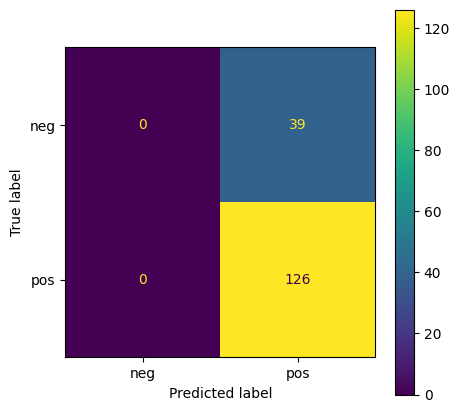

In [46]:
prediction2 = model2.predict(X_test)
# print("-"*15+"Support Vector Machine Model"+"-"*15)
acc2 = accuracy_score(y_test, prediction2)
showConfisionMatrix(y_test, prediction2)

In [47]:
model3 = MultinomialNB()
model3.fit(X_train, y_train)

MultinomialNB()

Accuracy score: 0.8061
------------------------------------------------------------
              precision    recall  f1-score   support

         neg       0.23      0.82      0.36        11
         pos       0.98      0.81      0.89       154

    accuracy                           0.81       165
   macro avg       0.61      0.81      0.62       165
weighted avg       0.93      0.81      0.85       165



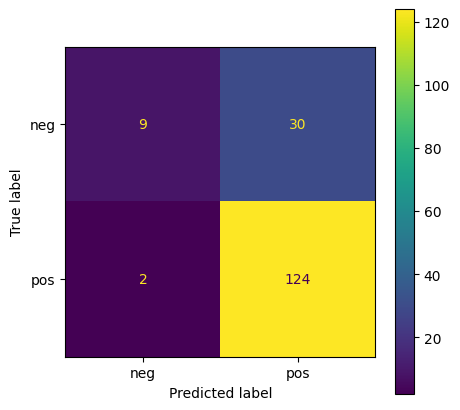

In [48]:
prediction3 = model3.predict(X_test)
# print("-"*20+"Naive Bayes Model"+"-"*20)
acc3 = accuracy_score(y_test, prediction3)
showConfisionMatrix(y_test, prediction3)

# การเปรียบเทียบค่าคะแนนความถูกต้องของ 3 Model

In [52]:
model_score = [["LogisticRegression",acc1],["SVM",acc2],["Naive bayes",acc3]]
df_test = pd.DataFrame(model_score, columns=['Classfier','Accuracy_score'])

In [53]:
df_test = df_test.sort_values('Accuracy_score', ascending=False)
df_test

,Classfier,Accuracy_score
0,LogisticRegression,0.836364
2,Naive bayes,0.806061
1,SVM,0.763636


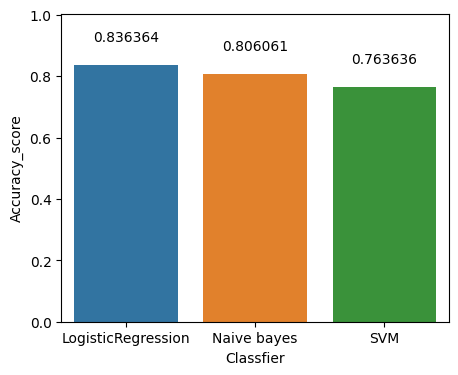

In [54]:
fig, ax = plt.subplots(figsize=(5, 4))
barchart = sns.barplot(x=df_test['Classfier'], y=df_test['Accuracy_score'])
barchart.bar_label(ax.containers[0], label_type='edge', padding=15)
ax.margins(y=0.2)

# Test Code Python

In [ ]:
def remove_digit(data):
    # memory = re.compile(")
    # price = re.compile()

    return data

In [ ]:
text = "ผมได้i14 128gbมาราคา26,000 จากโปรลดกลับเทรดเครื่องคุ้มมั้ยคับ"
remove_digit(text)

'ผมได้i14 มาราคา26, จากโปรลดกลับเทรดเครื่องคุ้มมั้ยคับ'

In [ ]:
def analyze_sentiment_AIforthai(df):
    api_key = "FOFZpO9UFwSMquHMwVmZ7cjebmv0Yv8a"
    results_df = pd.DataFrame(columns=["comment", "sentiment_data"])
    for index, row in df.iterrows():
        sentence_id = row[df['_id']]
        comment = row[df['textDisplay']]
        response = requests.post(
            "https://api.aiforthai.in.th/ssense",
            data={"text": comment},
            headers={"Apikey": api_key}
        )
        sentiment_data = dict(response.json())
        if sentiment_data["sentiment"]["score"] == "0":
            sentiment_data = "neu"
        else:
            sentiment_data = sentiment_data["sentiment"]['polarity'][:3]
        results_df.loc[index] = [sentence_id,comment, sentiment_data]
    return results_df